# Исследование мобильного приложения. Становой М.А.

### Блок подготовки

In [141]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
pd.options.mode.chained_assignment = None

# Инструменты для импорта файла из Я.Диска
import requests 
from urllib.parse import urlencode 

# И инструменты статистики
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import chi2_contingency

In [2]:
# Задаем новый стандартный размер для графиков seaborn 

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

&nbsp;
### Задача 1. Создание функции для расчета *retention* игроков

#### Цель:

Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

#### Этап 1. Подгрузка датасетов и разведочный анализ (EDA)

In [3]:
# Импортируем датасет с данными о регистрации пользователей в приложение

initial_reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')

In [4]:
# Проверим корректность подгрузки датасета

initial_reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
# Проверим основные параметры датасета, такие как:
# Кол-во строк и кол-во столбцов

initial_reg_data.shape

(1000000, 2)

In [6]:
# Установленные типы данных
# Ранее мы уже увидели, что дата регистрации приведена в виде timestamp'а
# следовательно, понадобится преобразовать этот столбец в datetime формат

initial_reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [7]:
# Проверим наличие незаполненных данных

initial_reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
# Проверим наличие дупликатов в записях о пользователях

initial_reg_data['uid'].duplicated().sum()

0

In [9]:
# Импортируем датасет с данными об авторизации пользователей в приложение

initial_auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')

In [10]:
# Проверим корректность подгрузки датасета

initial_auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
# Проверим основные параметры датасета, такие как:
# Кол-во строк и кол-во столбцов отличается от датасета с данными о регистрации
# Это связано с тем, что не все пользователи авторизовались в приложении после регистрации

initial_auth_data.shape

(9601013, 2)

In [12]:
# Установленные типы данных
# Ранее мы уже увидели, что дата регистрации приведена в виде timestamp'а
# следовательно, понадобится преобразовать этот столбец в datetime формат

initial_auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [13]:
# Проверим наличие дубликатов в записях о пользователях
# Очевидно, бОльшая часть пользователи авторизовывались в приложении многократно

initial_auth_data['uid'].duplicated().sum()

8601013

In [83]:
# Проверим кол-во уникальных пользователей в датасете с авторизациями

initial_auth_data['uid'].nunique()

1000000

In [84]:
# Проверим совпадение пользователей между датасетами с данными о регистрации и авторизации

initial_reg_data.merge(initial_auth_data, how='left', on='uid').uid.nunique()

1000000

In [14]:
# Создадим копию исходного датасета с данными о регистрации
# это позволит в любое время обратиться к исходным данным

df_reg = initial_reg_data.copy()

In [15]:
# Преобразуем данные о дате регистрации к типу datetime

df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s').dt.strftime('%Y-%m-%d')

In [16]:
# Переименуем колонку для удобства считывания информации

df_reg = df_reg.rename(columns={'reg_ts': 'reg_date'})

In [17]:
# Проверим корректность преобразований

df_reg.head(3)

,reg_date,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3


In [18]:
# Проверим максимальное и минимальное значения даты в полученном датасете

df_reg['reg_date'].max()

'2020-09-23'

In [19]:
# Обнаруживаем огромный временной разброс и подозрительную минимальную дату
# Понадобится проверить кол-во записей по всему датасету с заданным периодом

df_reg['reg_date'].min()

'1998-11-18'

In [20]:
# В качестве временного периода для проверки данных был выбран год

df_reg['reg_year'] = pd.to_datetime(df_reg['reg_date']).dt.year

In [21]:
# Проверим правильность получения года из даты

df_reg.head()

,reg_date,uid,reg_year
0,1998-11-18,1,1998
1,1999-07-22,2,1999
2,2000-01-13,3,2000
3,2000-05-28,4,2000
4,2000-09-16,5,2000


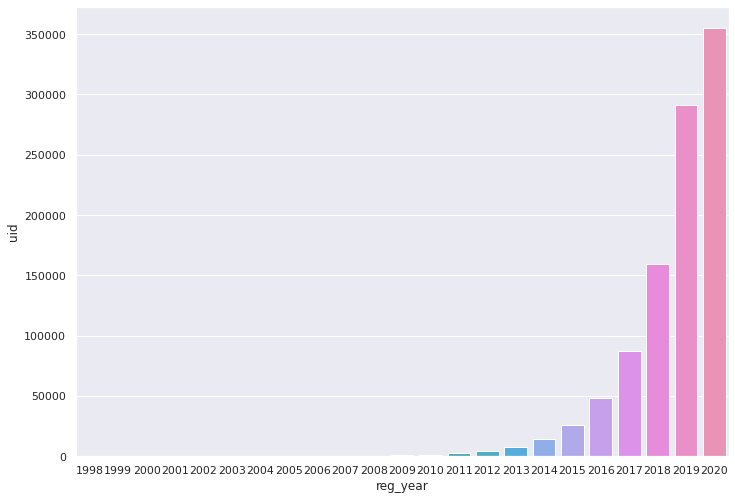

In [22]:
# Построим столбчатую диаграмму кол-ва уникальных пользователей от года их регистрации
# Перед тем как сделать окончательные выводы, проведем аналогичный анализ датасета с данными об авторизации

sns.barplot(data=df_reg.groupby('reg_year', as_index=False).agg({'uid': 'nunique'}), x='reg_year', y='uid')

In [23]:
# Аналогично создадим копию исходного датасета с данными об авторизации

df_auth = initial_auth_data.copy()

In [24]:
# Преобразуем данные о дате авторизации к типу datetime

df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s').dt.strftime('%Y-%m-%d')

In [25]:
# Переименуем колонку для удобства считывания информации

df_auth = df_auth.rename(columns={'auth_ts': 'auth_date'})

In [26]:
# Проверим корректность преобразований

df_auth.head(3)

,auth_date,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2


In [27]:
# Проверим максимальное и минимальное значения даты в полученном датасете

df_auth['auth_date'].max()

'2020-09-23'

In [28]:
# Видим аналогичную ситуацию с сильным временным разбросом

df_auth['auth_date'].min()

'1998-11-18'

In [29]:
# Произведем анализ кол-ва уникальных записей от года авторизации

df_auth['auth_year'] = pd.to_datetime(df_auth['auth_date']).dt.year

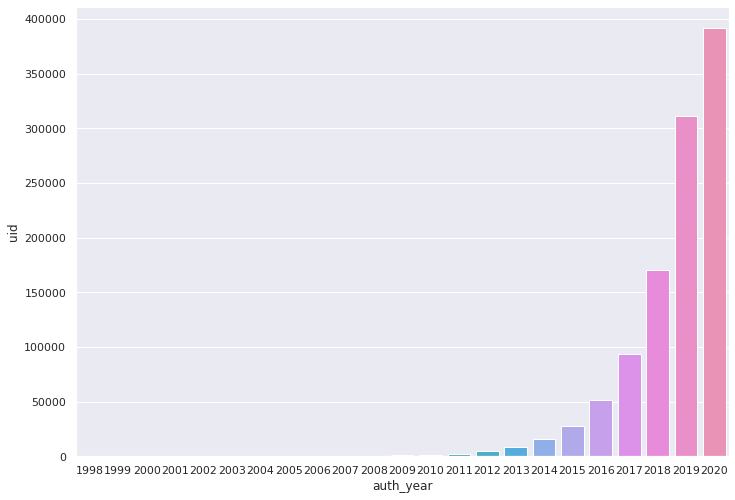

In [30]:
# Получаем идентичную ситуацию

sns.barplot(data=df_auth.groupby('auth_year', as_index=False).agg({'uid': 'nunique'}), x='auth_year', y='uid')

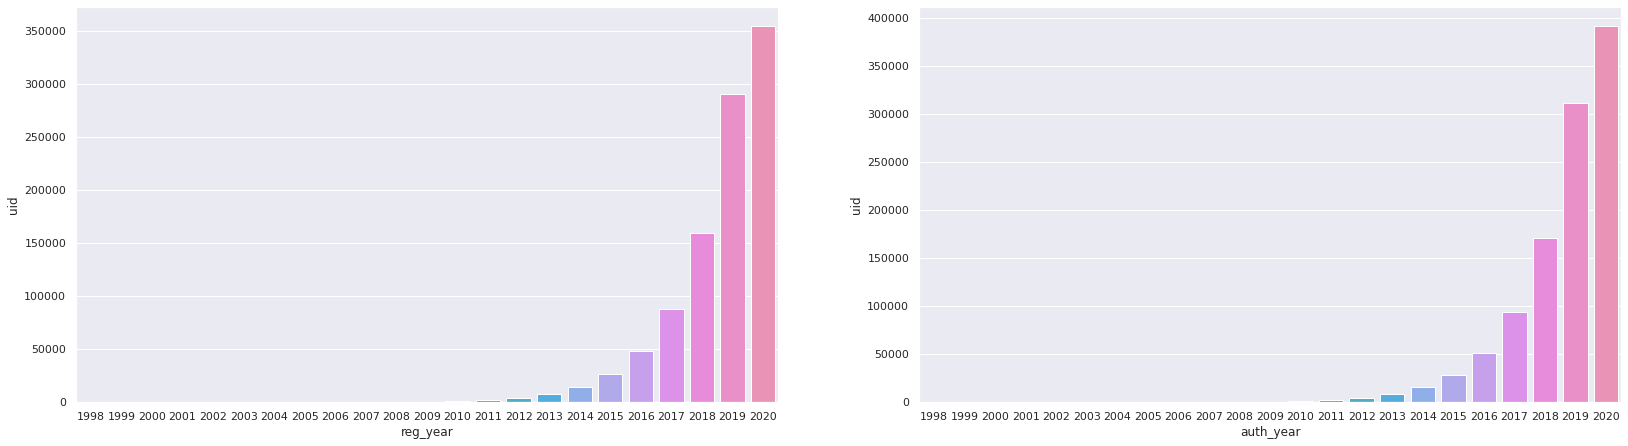

In [31]:
# Сопоставим диаграммы для лучшей наглядности

fig, ax = plt.subplots(1,2)

sns.barplot(data=df_reg.groupby('reg_year', as_index=False).agg({'uid': 'nunique'}), x='reg_year', y='uid', ax=ax[0])
sns.barplot(data=df_auth.groupby('auth_year', as_index=False).agg({'uid': 'nunique'}), x='auth_year', y='uid', ax=ax[1])

fig.set_size_inches(27.7, 7.27)
fig.show()

**Выводы по этапу подготовки данных:**

Данные о регистрации и авторизации пользователей имеют большой разброс. При этом, содержатся записи за подозрительно ранние даты. Это может свидетельствовать об ошибке в процессе сбора данных.

#### Этап 2. Подготовка датасета к расчету *retention*

In [32]:
# Объединим ранее рассмотренные датасеты
# При этом, объединение осуществим по левому датасету, что позволит отбросить пользователей, которые
# авторизовались, но не регистрировались

df = df_reg.merge(df_auth, on='uid', how='left')

In [33]:
# Проверим корректность объединения по столбцам

df.head(3)

,reg_date,uid,reg_year,auth_date,auth_year
0,1998-11-18,1,1998,1998-11-18,1998
1,1999-07-22,2,1999,1999-07-22,1999
2,1999-07-22,2,1999,1999-07-25,1999


In [34]:
# И по кол-ву строк

df.shape[0]

9601013

In [35]:
# Проверим наличие пропущенных данных

df.isna().sum()

reg_date     0
uid          0
reg_year     0
auth_date    0
auth_year    0
dtype: int64

In [36]:
# Отбросим колонки, использованные для построения гистограмм

df = df.drop(columns=['reg_year', 'auth_year'])

In [37]:
# Отсортируем датафрейм по возрастанию даты и обновим индексы

df = df.sort_values(by=['reg_date', 'auth_date'], ascending=True).reset_index(drop=True)

In [38]:
# Поменяем порядок оставшихся столбцов для удобства считывания информации

df = df[['uid', 'reg_date', 'auth_date']]

In [39]:
# Проверим корректность внесенных изменений

df.head()

,uid,reg_date,auth_date
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


#### Этап 3.1 Расчет *retention* всех игроков по дням от даты регистрации

Для расчета показателя *retention* всех игроков понадобится выполнить следующие шаги:

1. Рассчитать кол-во дней, прошедших с момента регистрации каждого игрока до авторизации в приложении
2. Собрать информацию о кол-ве людей, зашедших в приложение в день n
3. Рассчитать показатель *retention* n-го дня по формуле:

Retention (n-day) = ( кол-во игроков, вернувшихся в n-й день) / (кол-во игроков, зарегистрировавшихся n дней назад) * 100

4. Отрисовать линейную диаграмму для того, чтобы показать динамику изменений за весь период

In [106]:
# Создадим функцию, принимающую подготовленный датафрейм и число n, отражающее
# период за который мы смотрим retention в днях

def full_retention_rate(data, n):
    '''
    Возвращает линейную диаграмму, отражающую изменение показателя retention за период n.
        
        Параметры:
                data (pandas.DataFrame): датафрейм с данными о дате регистрации и авторизаций пользователя
                n (int): дата начала периоди когортного анализа
            
        Возвращаемое значение:
                sns.lineplot (seaborn.lineplot): Линейная диаграмма с динамикой изменения retention за период n
    '''
    
    # Рассчитаем кол-во дней, прошедших с момента регистрации каждого игрока до авторизации в приложении
    data['delta'] = (pd.to_datetime(data['auth_date']) - pd.to_datetime(data['reg_date'])).dt.days
    
    # Подготовим список, для сохранения рассчитанных показателей retention rate
    retention_by_days = []
    
    # Рассчитаем показатель retention и запишем полученное значение в ранее созданный список
    for day in range(0, n + 1):
        users_by_day = (data.query('delta == @day'))['uid'].nunique()
        retention_by_days.append(users_by_day / data['uid'].nunique() * 100)
    
    # Преобразуем список в датафрейм для возможности отрисовки графика с помощью seaborn
    dataframe = pd.DataFrame(retention_by_days)
    
    # Подготовим датафрейм для передачи в seaborn
    dataframe = dataframe.reset_index()
    dataframe = dataframe.rename(columns={'index': 'seniority', 0: 'retention'})
        
    # Вернем отрисованную по полученным данным линейную диаграмму
    return sns.lineplot(data=dataframe, x='seniority', y='retention', legend=False)

In [107]:
print(full_retention_rate.__doc__)


    Возвращает линейную диаграмму, отражающую изменение показателя retention за период n.
        
        Параметры:
                data (pandas.DataFrame): датафрейм с данными о дате регистрации и авторизаций пользователя
                n (int): дата начала периоди когортного анализа
            
        Возвращаемое значение:
                sns.lineplot (seaborn.lineplot): Линейная диаграмма с динамикой изменения retention за период n
    


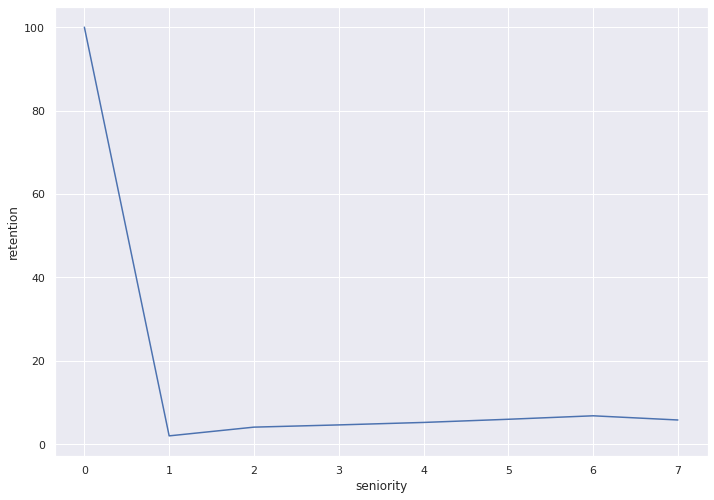

In [41]:
# Проверяем работу функции, смотрим динамику retention до 7-го дня включительно

full_retention_rate(df, 7)

#### Этап 3.2 Когортный анализ. Расчет *retention* для когорт

Проведем также расчет *retention* для когорт. Для этого понадобится:

1. Рассчитать кол-во дней, прошедших с момента регистрации каждого игрока до каждой его авторизации в приложении
2. Поделить пользователей на когорты (ввиду большого рассматриваемого временного периода, когорты возьмем по месяцам)
3. Рассчитать *retention rate* для каждой когорты по дням с момента регистрации
4. Построить тепловую карту для более наглядного представления динамики изменения *retention*

In [108]:
# Создадим функцию, принимающую подготовленный датасет, дату начала периода и дату конца периода

def cohort_retention_rate(data, start_date, end_date):
    ''' 
    Возвращает сводную таблицу с данными о retention за каждый день из заданного периода.
        
        Параметры:
                data (pandas.DataFrame): датафрейм с данными о дате регистрации и авторизаций пользователя
                start_date (str): дата начала периоди когортного анализа
                end_date (str): дата конца периода когортного анализа
            
        Возвращаемое значение:
                retention_df (pandas.DataFrame): Cводная таблица с данными о retention
    '''
    
    # Создадим копию входящего датасета
    filtered_df = data.copy()
    
    # Воспользуемся тем, что мы уже знаем в каком формате должны приходить данные в датасете :^)
    # и преобразуем их к нужному виду
    filtered_df['auth_date'] = pd.to_datetime(filtered_df['auth_date'])
    filtered_df['reg_date'] = pd.to_datetime(filtered_df['reg_date'])
    
    # Отфильтруем полученный датасет исходя из введенного пользователем периода
    filtered_df = filtered_df.query('reg_date >= @start_date & reg_date <= @end_date & \
                                    auth_date >= @start_date & auth_date <= @end_date')

    # Создадим колонку для названий когорт и преобразуем к строке,
    # чтобы при визуализации в seaborn когорты отображались нормально
    filtered_df['cohort'] = filtered_df['reg_date'].dt.strftime('%Y-%m-%d')
    
    # Рассчитаем кол-во дней, прошедших с момента регистрации игрока до авторизации в приложении
    filtered_df['seniority'] = (filtered_df['auth_date'] - filtered_df['reg_date']).dt.days
    
    # Сгруппируем пользователей по когортам внутри датасета и посчитаем кол-во активных пользователей
    group_df = filtered_df.groupby(['cohort', 'seniority']).agg({'uid': 'nunique'}).reset_index()
    
    # Преобразуем полученный ранее датасет в сводную таблицу
    pivot_df = group_df.pivot(index='cohort', columns='seniority', values='uid')
    
    # Сохраним данные о кол-ве игроков в день регистрации (нулевой день)
    day_zero_user_count = pivot_df[0]
    
    # Разделим каждое значение таблицы на кол-во игроков в нулевой день
    retention_df = pivot_df.divide(day_zero_user_count, axis=0).round(3)
    
    # Вернем полученный датафрейм
    return retention_df

In [109]:
print(cohort_retention_rate.__doc__)

 
    Возвращает сводную таблицу с данными о retention за каждый день из заданного периода.
        
        Параметры:
                data (pandas.DataFrame): датафрейм с данными о дате регистрации и авторизаций пользователя
                start_date (str): дата начала периоди когортного анализа
                end_date (str): дата конца периода когортного анализа
            
        Возвращаемое значение:
                retention_df (pandas.DataFrame): Cводная таблица с данными о retention
    


In [43]:
# Проверим работу функции на произвольном временном периоде

retention = cohort_retention_rate(df, "2020-01-01", "2020-02-01")

retention

seniority,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
cohort,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.0,0.026,0.045,0.034,0.057,0.058,0.075,0.050,0.044,0.044,...,0.035,0.027,0.038,0.031,0.040,0.036,0.033,0.033,0.024,0.031
2020-01-02,1.0,0.024,0.045,0.052,0.048,0.058,0.077,0.059,0.056,0.053,...,0.043,0.041,0.034,0.038,0.034,0.031,0.034,0.031,0.028,NaN
2020-01-03,1.0,0.023,0.034,0.044,0.045,0.069,0.075,0.054,0.045,0.042,...,0.038,0.031,0.032,0.038,0.036,0.025,0.024,0.029,NaN,NaN
2020-01-04,1.0,0.015,0.045,0.051,0.053,0.057,0.070,0.054,0.042,0.049,...,0.036,0.032,0.032,0.026,0.025,0.027,0.022,NaN,NaN,NaN
2020-01-05,1.0,0.020,0.045,0.046,0.044,0.048,0.079,0.052,0.039,0.054,...,0.034,0.038,0.035,0.037,0.032,0.036,NaN,NaN,NaN,NaN
2020-01-06,1.0,0.029,0.045,0.050,0.038,0.047,0.066,0.059,0.052,0.050,...,0.040,0.036,0.029,0.033,0.031,NaN,NaN,NaN,NaN,NaN
2020-01-07,1.0,0.019,0.049,0.044,0.064,0.050,0.085,0.051,0.057,0.053,...,0.039,0.043,0.038,0.033,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,1.0,0.022,0.040,0.043,0.051,0.050,0.085,0.050,0.045,0.062,...,0.035,0.041,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,1.0,0.019,0.040,0.055,0.045,0.060,0.067,0.057,0.051,0.047,...,0.033,0.035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


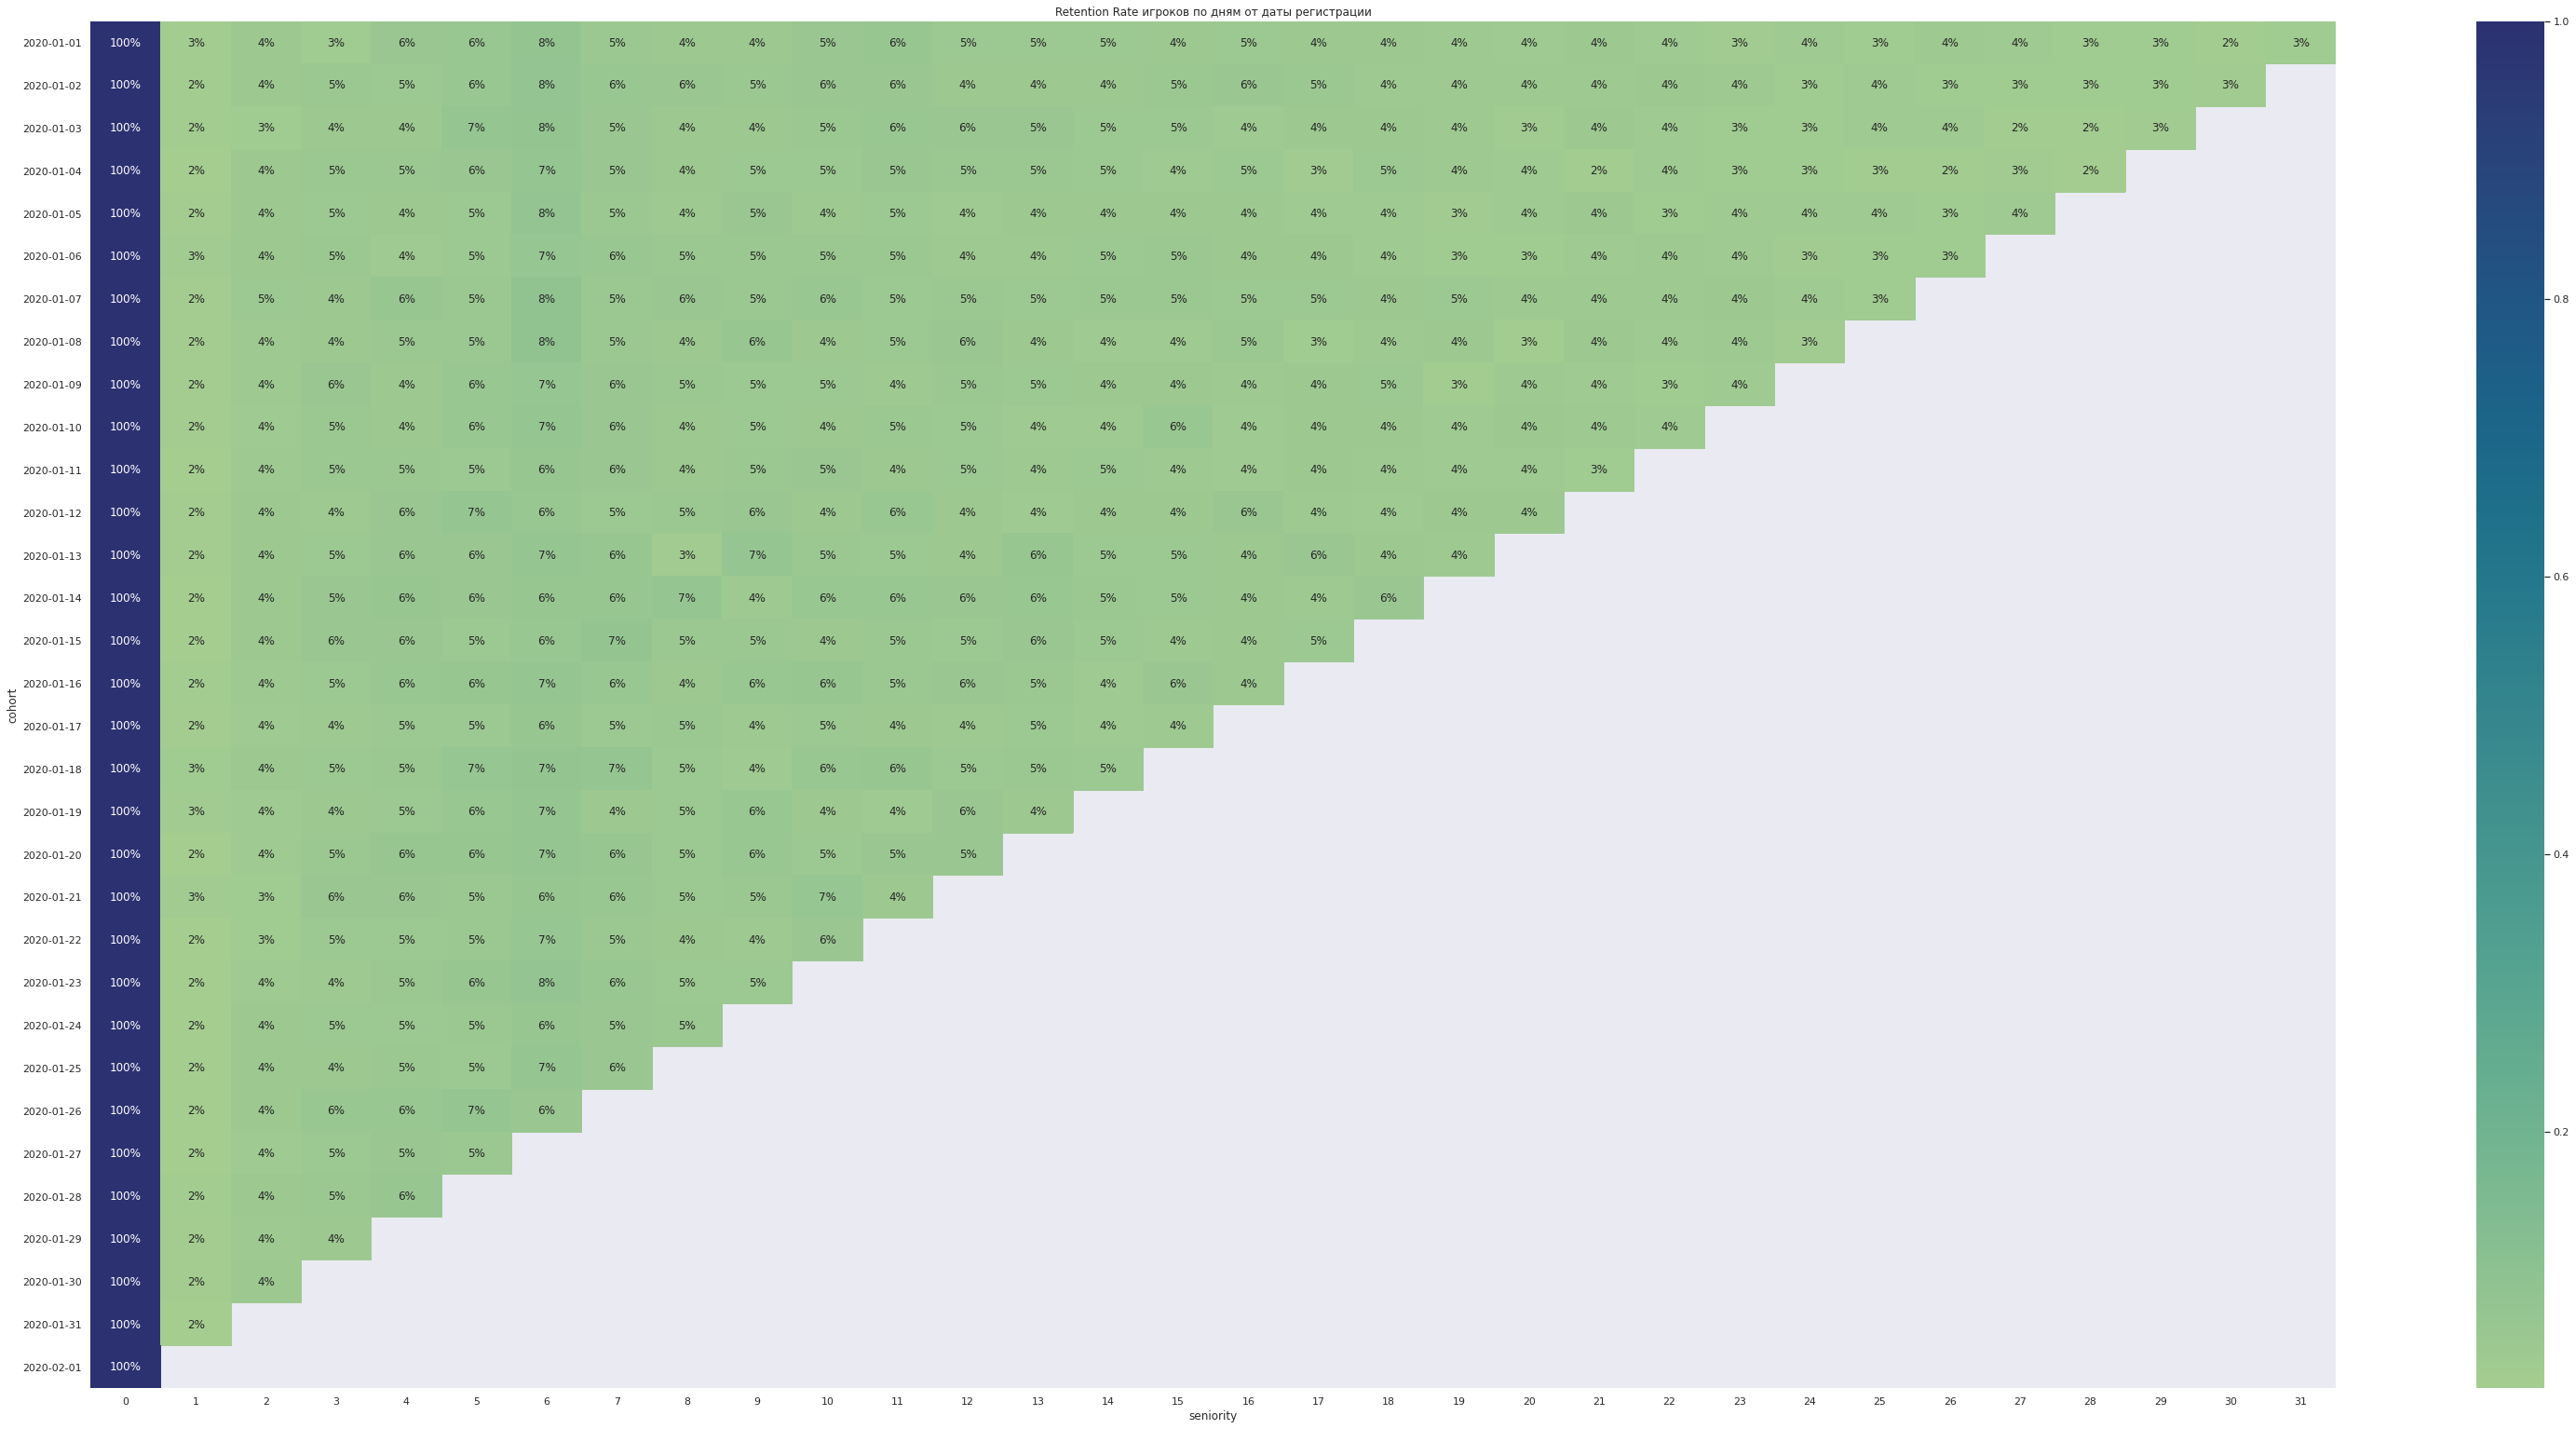

In [44]:
# Построим тепловую карту для полученных значений, при этом:

# Подгоним размер тепловой карты, чтобы она убралась полностью
# и названия когорт не наезжали на значения
plt.figure(figsize=(54, 27)) 

# Зададим ей название
plt.title('Retention Rate игроков по дням от даты регистрации')

# Отобразим значения показателя retention в процентах
sns.heatmap(data=retention, annot=True, fmt='.0%', cmap="crest")

&nbsp;
### Задача 2. Анализ A/B теста акционных предложений

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

#### Цель:
Определить какой набор предложений можно считать лучшим.

#### Этап 1. Импорт файлов из Я.Диска и разведочный анализ (EDA)

In [45]:
# Используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
 
# Получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# Загружаем файл в df 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep=';') 

In [46]:
# Проверим корректность подгрузки файла

df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [47]:
# Проверим датасет на наличие пропусков

df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [48]:
# Разобьем исходный датафрейм по категории отношения к тестовой группе

df_a = df.copy()
df_a = df_a.query('testgroup == "a"')

In [49]:
# Убедимся в правильности разбивки

df_a.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [50]:
# Проверим описательные статистики, чтобы определить к какой группе относится категория A

df_a.shape

(202103, 3)

In [51]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [52]:
df_a.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [53]:
# Подсчитаем кол-во платящих пользователей в группе А
# Можем сделать вывод, что группа А - контрольная

df_a_clients = df_a.query('revenue != 0').user_id.count()
df_a_clients

1928

In [54]:
# Проведем аналогичные операции для группы B

df_b = df.query('testgroup == "b"')

In [55]:
df_b.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


In [56]:
df_b.shape

(202667, 3)

In [57]:
df_b.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [58]:
df_b.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


In [59]:
# Подсчитаем кол-во платящих пользователей в группе B (тестовой)

df_b_clients = df_b.query('revenue != 0').user_id.count()
df_b_clients

1805

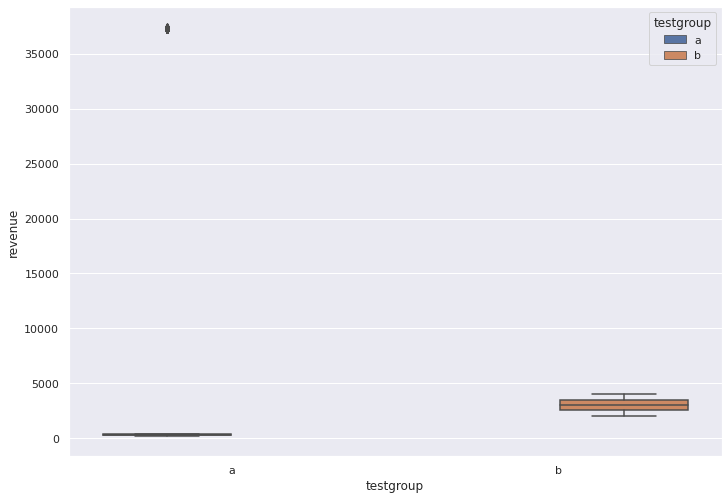

In [60]:
# Сравним показатели revenue для обеих групп с помощью боксплота

sns.boxplot(data=df.query('revenue != 0'), y='revenue', x='testgroup', hue='testgroup', order=['a', 'b'], )

**Комментарий:**

Боксплоты "прижались" к оси x. Видим, что контрольная группа содержит в себе значительные выбросы с значениями *revenue* более 35000. Попробуем отсечь данные записи и проверить боксплот заново.

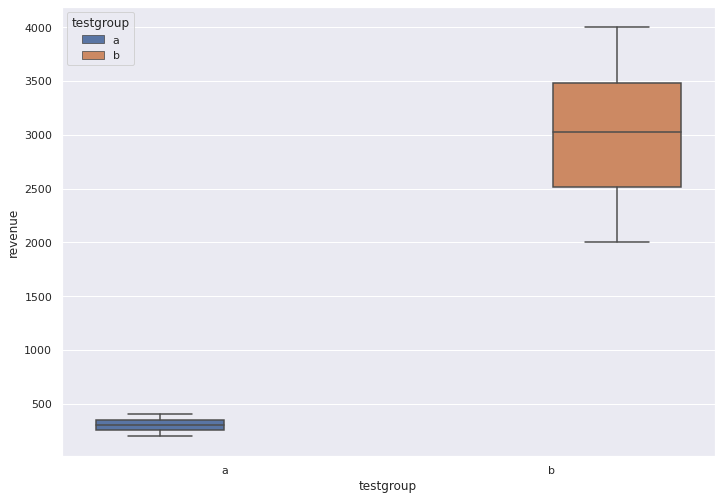

In [61]:
# Сравним показатели revenue для обеих групп с помощью боксплота

sns.boxplot(data=df.query('revenue != 0 & revenue < 35000'), y='revenue', x='testgroup', hue='testgroup', order=['a', 'b'], )

**Комментарий:**

В результате отсечения выбросов в контрольной группе (группе А) мы можем увидеть заметное различие в показателях *revenue* для контрольной и тестовой групп.

**Выводы по данному этапу:**

Наличие выбросов в контрольной группе может говорить об ошибке на этапе сплитования аудитории.

А может говорить и о том, что таковым является диапазон цен акционных предложений и что в тестовой группе акционные предложения с более дорогим ценником не предлагались пользователям. Проще говоря, не имея уточняющих данных о контексте проводимого исследования мы не можем говорить о том, что такие смещения являются выбросами (тем более, что бОльшие платежи как раз-таки приносят бОльшую часть выручки в контрольной группе).

Следовательно, останавливаемся на варианте с тем, что преобразовывать данные в контрольной группе не надо.

#### Этап 2. Подготовка к анализу результатов A/B теста

**Определение статистического метода для оценки результатов A/B теста**

Для выбора корректного теста необходимо рассмотреть следующие шаги:

1. Являются ли сравниваемые величины количественными или категориальными?

В нашем случае, мы будем сравнивать изменение значения *Revenue*. Следовательно, величина количественная и непрерывная.

2. Тип исследовательского вопроса?

Сравнение различий.

3. Что сравниваем?

Средние (t-критерий Стьюдента) и конверсию (Хи-квадрат)

4. Какое кол-во групп мы сравниваем?

Количество сравниваемых групп - 2

5. Удовлетворяются ли параметрические условия?

Осуществим проверку данных на выполнение параметрических условий двумя методами:

    * Визуальным

    * Тестом Шапиро-Уилка

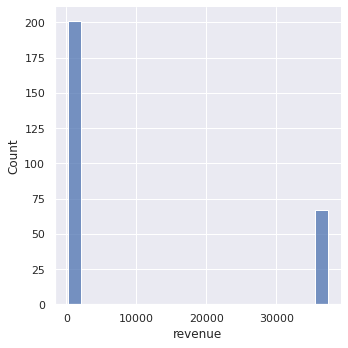

In [85]:
# Проверим нормальность распределений визуальным способом, для этого
# построим гистограммы для обеих групп

sns.displot(data=df.query('testgroup == "a" & revenue != 0').groupby('revenue', as_index=False).agg({'user_id': 'count'}), x='revenue', bins=20)

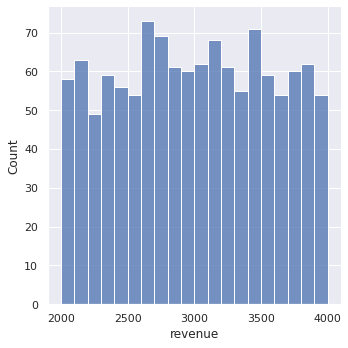

In [63]:
sns.displot(data=df.query('testgroup == "b" & revenue != 0').groupby('revenue', as_index=False).agg({'user_id': 'count'}), x='revenue', bins=20)

**Комментарий:**

Видим, что распределения не являются нормальными. Осуществим дополнительную проверку с помощью теста Шапиро-Уилка.

In [64]:
# Подготовим датасет с контрольной группой для проверки тестом Шапиро-Уилка

df_a_group = df.query('testgroup == "a" & revenue != 0').groupby('revenue', as_index=False).agg({'user_id': 'count'})

In [65]:
# Подготовим датасет с тестовой группой для проверки тестом Шапиро-Уилка

df_b_group = df.query('testgroup == "b" & revenue != 0').groupby('revenue', as_index=False).agg({'user_id': 'count'})

In [66]:
shapiro(df_a_group['revenue'])

ShapiroResult(statistic=0.9546118378639221, pvalue=5.123054961586604e-06)

In [67]:
# В обоих случаях тест Шапиро-Уилка показал pvalue < 0.05, поэтому можем отвергнуть нулевую гипотезу о том,
# что распределение не является нормальным

shapiro(df_b_group['revenue'])

ShapiroResult(statistic=0.9595694541931152, pvalue=8.611232245265899e-18)

**Выбор теста**:

Для проведения проверки стат. значимости разницы между акционными предложениями воспользуемся t-критерием Стьюдента, т.к. несмотря на ненормальный характер имеющихся распределений, согласно ЦПТ для выборок с большим количеством наблюдений точность определения будет близка к таковому у нормального распределения.

#### Этап 3. Непосредственный анализ результатов A/B теста

Посчитаем также продуктовые метрики, чтобы лучше понимать разницу между контрольной и тестовой группами.

In [69]:
# Рассчитаем ARPPU для контрольной группы

ARPPU_a = df_a.query('revenue != 0').revenue.mean()
ARPPU_a

2663.9984439834025

In [70]:
# Рассчитаем ARPPU для тестовой группы

ARPPU_b = df_b.query('revenue != 0').revenue.mean()
ARPPU_b

3003.6581717451522

In [72]:
# ARPU для контрольной группы без выбросов

df_a.revenue.mean()

25.413719736965806

In [73]:
# И для тестовой группы

df_b.revenue.mean()

26.75128659327863

In [112]:
# Рассчитаем конверсию в клиента для контрольной группы

Conversion_a = df_a.query('revenue != 0').user_id.count() / df_a.user_id.count()
Conversion_a

0.009539690157988749

In [113]:
# Рассчитаем конверсию в клиента для тестовой группы
# Конверсия у тестовой группы уменьшилась!

Conversion_b = df_b.query('revenue != 0').user_id.count() / df_a.user_id.count()
Conversion_b

0.008931089592930338

In [79]:
# Не смотря на то, что текущее распределение не является нормальным, ЦПТ говорит о возможности использования
# t-критерия Стьюдента для выборок с большим кол-вом наблюдений

# H0 - Средние значения *revenue* не отличаются
# H1 - Средние значения *revenue* имеют статистически значимые различия


# Сравним средние показатели revenue
# p-value > 0.05, а значит оснований отклонить нулевую гипотезу у нас нет

stats.ttest_ind(df_a['revenue'], df_b['revenue'])

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

In [123]:
# Проверим стат. значимость различий в конверсии между тестовой и контрольной группами
# Для этого воспользуемся статистикой Хи-квадрат, но для начала подготовим данные
# Создадим колонки, показывающие был ли конвертирован каждый из пользователей проверяемых групп

df_a['converted'] = df_a.revenue != 0
df_a['converted'] = df_a['converted'].astype(int)

In [125]:
df_a.head()

,user_id,revenue,testgroup,converted
1,2,0,a,0
2,3,0,a,0
9,10,0,a,0
10,11,0,a,0
11,12,0,a,0


In [126]:
df_b['converted'] = df_b.revenue != 0
df_b['converted'] = df_b['converted'].astype(int)

In [127]:
df_b.head()

,user_id,revenue,testgroup,converted
0,1,0,b,0
3,4,0,b,0
4,5,0,b,0
5,6,0,b,0
6,7,0,b,0


In [128]:
# Подсчитаем кол-во конвертированных и неконвертированных пользователей в исследуемых группах

a_clients = df_a.converted.sum()
a_not_clients = df_a.converted.size - df_a.converted.sum()

b_clients = df_b.converted.sum()
b_not_clients = df_b.converted.size - df_b.converted.sum()

In [148]:
# Создадим таблицу сопряженности 

contingency_table = np.array([[a_clients, a_not_clients], [b_clients, b_not_clients]])
contingency_table

array([[  1928, 200175],
       [  1805, 200862]])

In [151]:
# Применим к полученной таблице статистику Хи-квадрат

# H0: тестовая и контрольная группы не отличаются друг от друга по влиянию на конверсию в клиента
# H1: тестовая и контрольная группы отличаются друг от друга по влиянию на конверсию в клиента

# Полученный p-value < 0.05, следовательно отклоняем нулевую гипотезу
# Различия в конверсиях в исследуемых группах статистически значимы

chi2_contingency(contingency_table)[1]

0.03647561892312613

#### Выводы

В результате исследования результатов A/B теста было обнаружено:

1. Наличие возможных выбросов в контрольной группе (группе А)
2. В тестовой группе (группе B) конверсия стала меньше. Следовательно, рост *ARPPU* не связан с привлечением новых клиентов
3. Распределения *revenue* для каждой из групп не являются нормальными. Тем не менее, размер выборки позволяет применить t-критерий Стьюдента, опираясь на ЦПТ
4. Тест t-критерия Стьюдента показал отсутствие статистической значимой разницы ARPU в тестовой и контрольной группах
5. Статистика Хи-квадрат показала стат. значимое различие между конверсиями тестовой и контрольной групп. При этом тестовая группа показывает бОльшую конверсию

Таким образом, на основании проведенного исследования можно сделать вывод о том, что контрольная группа (группа A) имеет более эффективный набор акционных предложений. Оставляем набор акционных предложений из данной группы.

&nbsp;
### Задача 3. Анализ усложнения механик тематических событий

#### Условие задачи:

*Сценарий 1:*
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время.

**Вопрос:** С помощью каких метрик можно оценить результаты последнего прошедшего события?

*Сценарий 2:*
Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 

**Вопрос:** Изменится ли набор метрик оценки результата? Если да, то как?

#### Сценарий 1. Оценка последнего прошедшего тематического события

Постараемся подобрать оптимальный набор метрик для данного сценария, основываясь на критериях хороших метрик, а именно:
+ **Доступная для понимания** — вся команда понимает, что значит эта метрика, так как она незамысловата
+ **Чувствительная** — метрика сразу отразит какие-то проблемы в одном или нескольких направлениях
+ **Actionable** — метрика несет смысл, и ее динамика или сравнение с другими метриками нам о чём-то говорит и меняет наше поведение
+ **Быстрая** — нам не нужно ждать конца месяца, чтобы посчитать эту метрику. Ценятся те метрики, которые можно измерять риалтайм и реагировать
+ **Релевантная** — относится к нашим целям и тому, что мы хотим понять или узнать

**Метрики аудитории:**

В данном сценарии можно использовать метрики для оценки изменения в аудитории продукта, такие как:
* *Дневная аудитория (DAU)*

Она может быть ценна для нас, т.к. позволит отследить изменения в кол-ве уникальных посетителей до начала события, во время  события и после события. При этом она будет более чувствительна к изучаемым изменениям по сравнению с MAU (тем более, что события происходят ежемесячно).
* *Месячная аудитория (DAU)*

В данном случае может понадобится при сравнении нескольких событий, произошедших в разные месяцы, между собой. Например, если понадобится сравнить последнее событие со всеми предыдущими.
* *Количество новых пользователей за месяц*

Может помочь отследить насколько эффективно текущее событие привлекает именно новую аудиторию. Например, может позволить сравнить кол-во новых пользователей за месяц прошедшего события со всеми предыдущими.

**Воронка и конверсия**

В данном сценарии в качестве воронки может рассматриваться следующая последовательность:

    V Кол-во уникальных пользователей

      V Кол-во игроков, перешедших на "таб/экран" (тапнувших на push-уведомление) события
    
        V Кол-во игроков, принявших участие в событии
        
          V Кол-во игроков, прошедших первый уровень
            
            V Кол-во игроков, прошедших n-й уровень
                
              V Кол-во игроков, прошедших последний уровень
                    
                V Кол-во игроков, получивших уникальную награду события (если она не выдается сразу)
                
В таком случае, мы можем рассмотреть абсолютную и относительную конверсии для каждого из этих шагов. При этом, каждая из них может оказать свою уникальную ценность:
* *Конверсия игроков, перешедших на "таб/экран" события*

Может показать насколько хорошо информированны пользователи о проходящем в текущее время событии.
* *Конверсия игроков, принявших участие в событии*

Может показать первое впечатление пользователя о событии. Например, он мог перейти по заинтересовавшему его уведомлению, но тут же разачароваться в условиях проведения события.
* *Конверсия игроков, прошедших первый уровень*

Указывает на то, что игрок принял решение опробовать событие.
* *Конверсия игроков, прошедших n-й уровень*

Может показывать на "узкие места". Т.е. те уровни, которые сильнее всего отпугивают игроков от дальнейшего участия в событии.
* *Конверсия игроков, прошедших последний уровень*

Указывает на то, какой процент людей прошел событие полностью.
* *Конверсия игроков, получивших уникальную награду события*

В случае, если награда выдается не сразу (или забирать ее надо вручную), может показать насколько эффективно игра напоминает пользователю о необходимости забрать вознаграждение. Хотя этот уровень воронки, конечно, несколько спорный.

**Retention**

*Retention n-го дня* может показать насколько хорошо событие удерживает пользователей в приложении, при этом день за который мы будем считать удержание будет зависеть от длительности события (так же как и деление на когорты, в данном случае дневные или недельные).

**Показатели доходов**

Могут быть применены для оценки экономической эффективности события. Мы можем рассмотреть *конверсию в целевое действие*, связанное с текущим тематическим событием (например, покупку боевого пропуска, наборов предметов, подписку на ежедневные расходники и бустеры опыта, и т.д.).

В таком случае, можно будет рассчитать *ARPPU (Average revenue per paying user)* и *ARPU (Average revenue per user)* и сравнить результаты с предыдущими событиями.

**Показатели расходов**

* CAC (или стоимость привлечения клиента)

Исходя из предыдущего пункта, может позволить оценить расходы на привлечение игроков, совершивших нужное нам целевое действие, связанное с монетизацией.

**Метрики удовлетворенности клиентов**

Среди данной категории можно воспользоваться *оценкой удовлетворенности клиентов (CSAT)*, проведя сбор оценок события.

Также можно посмотреть на динамику изменения оценок на платформе, через которую распространяется приложение (*App Store*, *Play Маркет* и т.д.).

Так, например, в компьютерном сегменте видеоигр зачастую актуальные мнения пользователей можно получить из отзывов на платформах (*Steam, недавние отзывы*).

**Прочие метрики**

Среди прочих метрик можно также посмотреть на изменения средней продолжительность сессии (ASL) до события, во время события и после него.

#### Сценарий 2. Изменение механик события

В связи с тем, что в данном сценарии меняются не просто механики уровней, а механики переходов между ними (по сути, прямо влияющие на поведение воронки и конверсии между ее уровнями), то, возможно, стоит добавить дополнительные метрики, позволившие бы лучше отслеживать влияние "откатов" с уровня в случае неудачи.

Например, можно отслеживать *суммарное время, проведенное пользователем на каком-либо уровне* (за все попытки), либо считать *кол-во откатов с того или иного уровня*.

Можно также посмотреть *retention* для пользователей по дням от даты последнего "отката". Это позволит оценить насколько данная механика отпугивает игроков от события/игры в целом.